# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: XGBoost
- performs well with sparse variables
- needs no preprocessing

In [11]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning, RuntimeWarning))

In [2]:
# Set up directories
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split into training and testing sets
k = StratifiedKFold(n_splits=5, random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75,
                                                      stratify=k, random_state=7149)

# Set up classifier
clf = XGBClassifier(n_estimators=1000, random_state=47, n_jobs=4)

Loaded 34955 samples with 4456 features


In [5]:
# Define eval function: F1-score
def f1_eval(y, t):
    y_true = t.get_label()
    y_pred = [1. if y_i > 0.5 else 0. for y_i in y] # binarize output
    
    f1_error = 1 - f1_score(y_true, y_pred)
    return 'f1-error', f1_error

# Define objective function
def objective(params):
    _ = clf.set_params(**params)
    _ = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                eval_metric=f1_eval, early_stopping_rounds=100,
                verbose=False)
    
    score = f1_score(y_valid, clf.predict(X_valid, ntree_limit=clf.best_ntree_limit))
    
    return {'loss': -score, 'status': STATUS_OK}

In [6]:
# Define hyperparameter search space
param_space = {
    'max_depth': hp.choice('max_depth', range(1, 101)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 2.0),
    'min_child_weight': hp.choice('min_child_weight', range(16)),
    'max_delta_step': hp.choice('max_delta_step', range(31)),
    'gamma': hp.uniform('gamma', 0, 5),
    
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 1, 30),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 20)
}

# Begin optimization
trials = Trials()
best = fmin(objective, param_space, algo=tpe.suggest, max_evals=300, trials=trials)

# Obtain parameters of best model
best_params = space_eval(param_space, best)
best_params

100%|██████████| 300/300 [1:46:39<00:00, 29.14s/it, best loss: -0.7419962335216571]


{'colsample_bylevel': 0.9179562854259685,
 'colsample_bytree': 0.31151759924834105,
 'gamma': 0.0445466581941214,
 'learning_rate': 0.8694754244763027,
 'max_delta_step': 8,
 'max_depth': 20,
 'min_child_weight': 0,
 'reg_alpha': 0.6051458064436968,
 'reg_lambda': 6.395353788666904,
 'scale_pos_weight': 9.176117679554167,
 'subsample': 0.91613328781734}

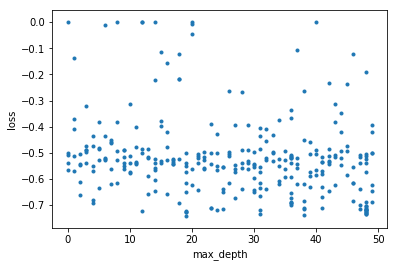

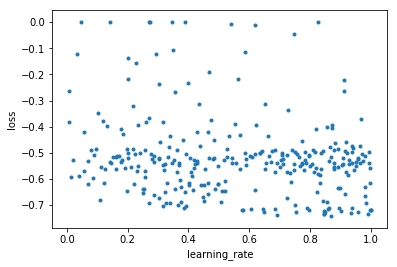

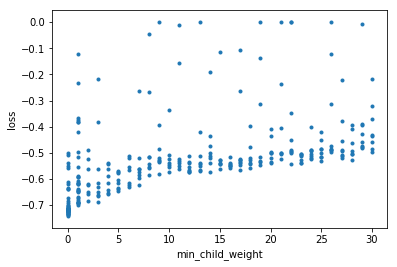

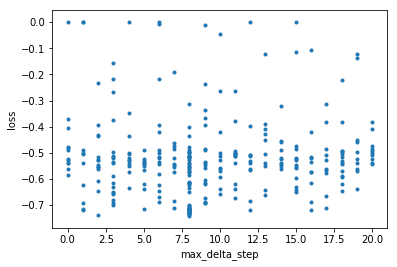

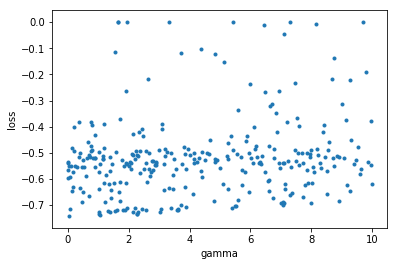

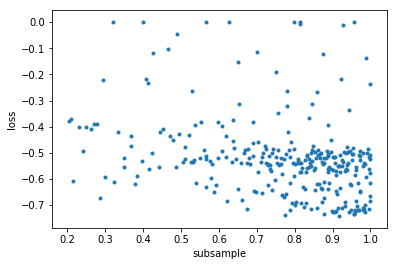

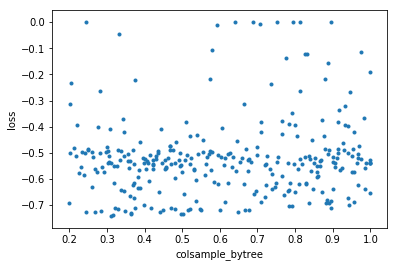

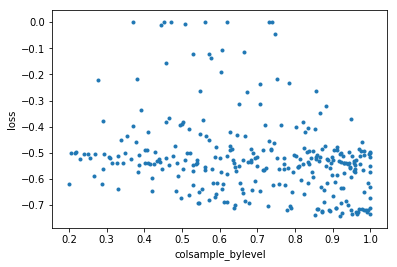

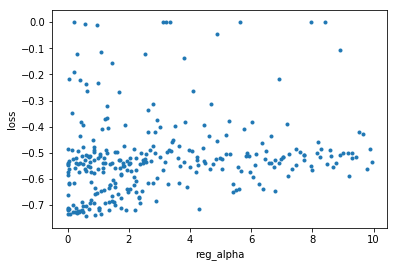

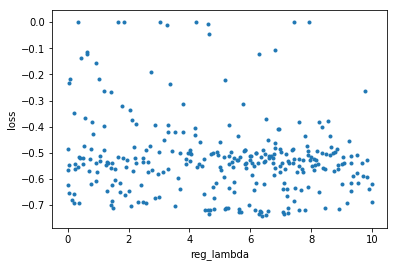

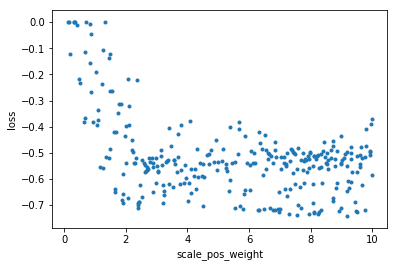

In [7]:
# Plot optimization progress: params vs loss
%matplotlib inline

for param in param_space.keys():
    xs = [t['misc']['vals'][param] for t in trials.trials]
    ys = [t['result']['loss'] for t in trials.trials]
    
    _ = plt.scatter(xs, ys, marker='.')
    _ = plt.xlabel(param)
    _ = plt.ylabel('loss')
    _ = plt.show()

In [8]:
# Set up classifier
_ = clf.set_params(**best_params, n_jobs=-1)

# Train with validation
_ = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
            eval_metric=f1_eval, early_stopping_rounds=100,
            verbose=1)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')

[0]	validation_0-error:0.661975	validation_0-f1-error:0.612493
Multiple eval metrics have been passed: 'validation_0-f1-error' will be used for early stopping.

Will train until validation_0-f1-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.5678	validation_0-f1-error:0.581303
[2]	validation_0-error:0.540909	validation_0-f1-error:0.570136
[3]	validation_0-error:0.497883	validation_0-f1-error:0.552087
[4]	validation_0-error:0.453713	validation_0-f1-error:0.533289
[5]	validation_0-error:0.414121	validation_0-f1-error:0.513406
[6]	validation_0-error:0.402106	validation_0-f1-error:0.506632
[7]	validation_0-error:0.394439	validation_0-f1-error:0.50109
[8]	validation_0-error:0.377846	validation_0-f1-error:0.496094
[9]	validation_0-error:0.363543	validation_0-f1-error:0.487195
[10]	validation_0-error:0.370866	validation_0-f1-error:0.489651
[11]	validation_0-error:0.362742	validation_0-f1-error:0.484709
[12]	validation_0-error:0.358966	validation_0-f1-error:0.48269
[13]	validatio

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9109    0.8349    0.8713     10777
           1     0.5143    0.6816    0.5863      2764

    accuracy                         0.8036     13541
   macro avg     0.7126    0.7583    0.7288     13541
weighted avg     0.8300    0.8036    0.8131     13541



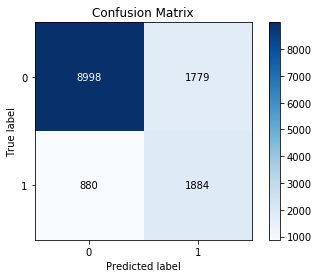

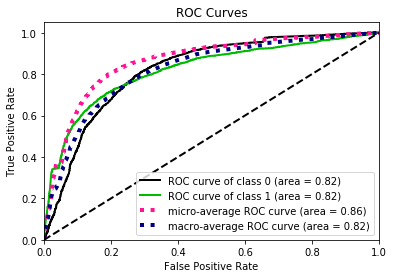

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9104    0.8756    0.8927     13137
           1     0.6007    0.6847    0.6399      3590

    accuracy                         0.8346     16727
   macro avg     0.7555    0.7801    0.7663     16727
weighted avg     0.8439    0.8346    0.8384     16727



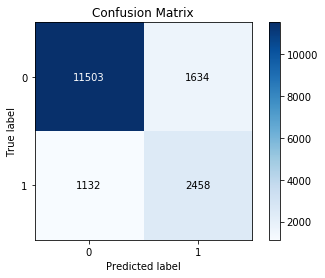

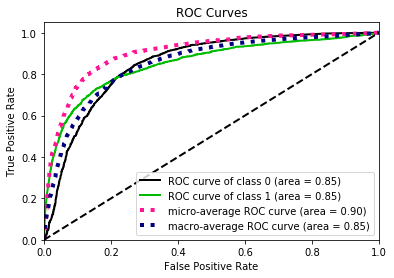

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9040    0.9206    0.9122      3500
           1     0.7524    0.7119    0.7316      1187

    accuracy                         0.8677      4687
   macro avg     0.8282    0.8162    0.8219      4687
weighted avg     0.8656    0.8677    0.8665      4687



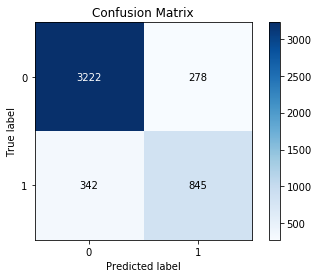

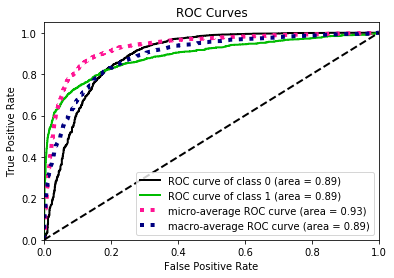

<hr></hr>

In [10]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier with validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.75,
                                                          random_state=47)
    
    _ = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                eval_metric=f1_eval, early_stopping_rounds=100,
                verbose=0)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))